# Plot functionality for stk_search (July 2024)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.posteriors.gpytorch import scalarize_posterior
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean 
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch import test_functions
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math
import matplotlib.pyplot as plt
import random
import time
import pickle
import os
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")
def compute_cumulative_cost(fidelity_history):
    cumulative_cost = [fidelity_history[0]]
    for i in range(len(fidelity_history) - 1):
        cumulative_cost.append(cumulative_cost[-1] + fidelity_history[i+1])
    return cumulative_cost

In [3]:
# results=np.load('STK_batch/20240709-183733', allow_pickle=True)
# results=np.load('STK_batch/20240713-100153', allow_pickle=True)
results=np.load('notebooks/STK_Data/20240713-220959', allow_pickle=True)

cumulative_cost = compute_cumulative_cost(results['MF-Custom'][0]['searched_space_df']['fidelity'].values)
modelDict={}
not_sfei= [key for key in results.keys() if key != 'SF-EI']
for key in not_sfei:
    modelDict[key] = (results[key][0]['searched_space_df'].values, 
                      np.array(results[key][0]['fitness_acquired']), 
                      compute_cumulative_cost(results[key][0]['searched_space_df']['fidelity'].values))

modelDict['SF-EI'] = (np.concatenate((results['SF-EI'][0]['searched_space_df'].values, np.ones(len(results['SF-EI'][0]['searched_space_df'].values)).reshape(-1,1)),axis=1), 
                      np.array(results['SF-EI'][0]['fitness_acquired']), 
                      compute_cumulative_cost(np.ones(len(results['SF-EI'][0]['searched_space_df'].values))))

    

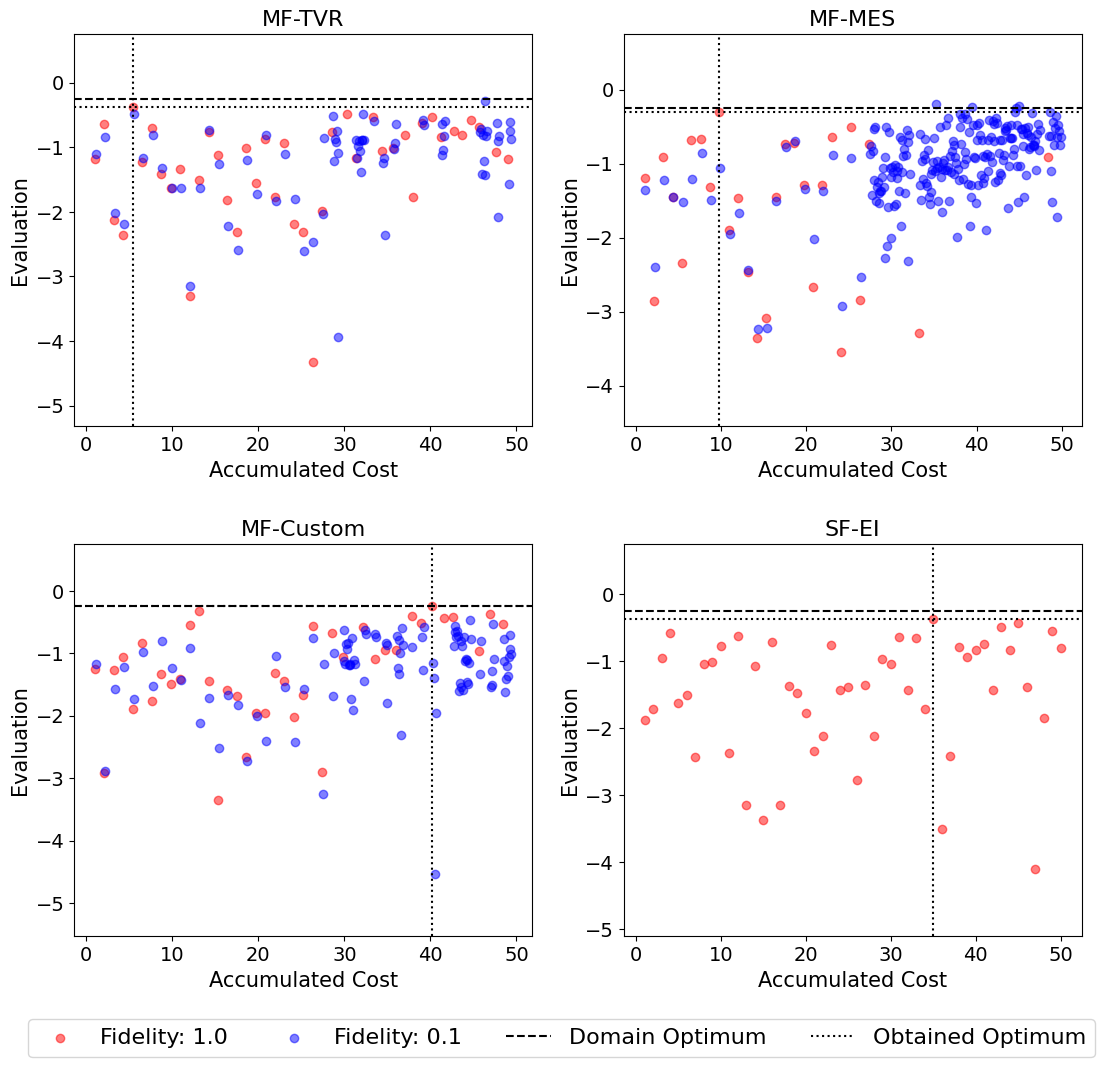

In [7]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def plot_fidelities(samples, targets, cumulated_cost, title, total_domain, colours=['red', 'blue', 'green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, -1] == 1.0)][:, -2])
    # samples = samples.detach().numpy()
    # targets = targets.detach().numpy()
    max_reached = targets[np.where(samples[:, -1] == 1.0)].max()
    index_of_max = np.where(targets == max_reached)[0].item()
    fidelities = list(dict.fromkeys(np.round(samples[:, -1].astype(float), 3)))
    fidelities.sort(reverse=True)
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(len(cumulated_cost)):
            if (round(samples[i, -1],3) == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(cumulated_cost[i])
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {round(fidelity, 3)}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)], alpha=0.5)
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Domain Optimum')
    plt.axvline(x=cumulated_cost[index_of_max], color='black', linestyle=':')
    plt.axhline(y=max_reached, color='black', linestyle=':', label='Obtained Optimum')

    # plt.legend()
    plt.xlabel("Accumulated Cost")
    plt.ylabel("Evaluation")
    plt.ylim([min(targets)-1, max_in_space +1])
    plt.title(title)

def plot_fidelities_for_dict(dictionary, dictionary_domain, allocated_budget=100, number_init=25):
    figure = plt.figure(figsize=(13,11))
    no_of_rows = math.ceil(len(dictionary.keys())/2)
    for id, key in enumerate(list(dictionary.keys())[:-1]):
        plt.subplot(no_of_rows, 2, id + 1)
        plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    handles, labels = plt.gca().get_legend_handles_labels()
    for key in list(dictionary.keys())[-1:]:
        plt.subplot(2, 2, 4)
        plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    figure.subplots_adjust(hspace=0.3)
    plt.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor = (0, -0.01, 1, 1),
           bbox_transform = plt.gcf().transFigure)
    plt.subplots_adjust(top=0.93)
    plt.show()

domain = pd.read_csv('data/oligomer_data.csv', delimiter=',').values
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=16)
plt.rc('axes', titlesize=16) 
plot_fidelities_for_dict(modelDict, domain, allocated_budget=50)
plt.style.use('default')



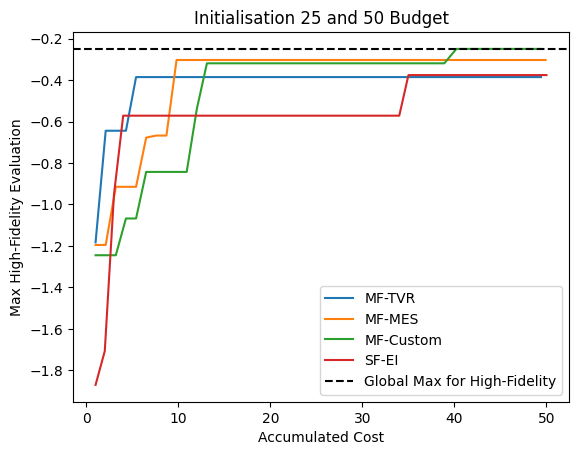

In [8]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    max_in_space= np.max(domain[np.where(domain[:, -1] == 1.0)][:, -2])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = train_x_full[:, -1] ==1.0
        high_fidelity_obj = train_obj[hf_indices]
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        #Make sure last element is also hf just for visual purposes of the graph.
        if hf_indices[-1] == False:
            accum_target.append(accum_target[-1])
            hf_indices[-1] = True
        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.title(title)
    plt.legend()

plot_cost(domain, modelDict,f'Initialisation {25} and {50} Budget' )

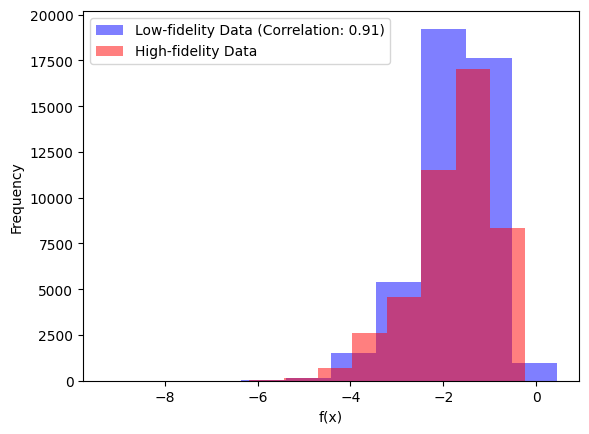

In [9]:
#Represent domain
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, -1]==1.0)]
    low_fidelity = domain[np.where(domain[:, -1]!= 1.0)]
    correlation = np.corrcoef(high_fidelity[:, -2].astype(float), low_fidelity[:, -2].astype(float))[0,1]

    plt.hist(low_fidelity[:, -2], label=f'Low-fidelity Data (Correlation: {str(correlation)[:4]})', bins=10, alpha=0.5, color='blue')
    plt.hist(high_fidelity[:, -2], label='High-fidelity Data', bins=10, alpha=0.5, color='red')
    # plt.title('Distribution of Evaluations')
    plt.xlabel('f(x)')
    plt.ylabel('Frequency')
    plt.legend()
domain_single= pd.read_csv('data/oligomer_data.csv', delimiter=',').values
plot_histogram(domain_single)

In [11]:
# Batch
ALLOCATED_BUDGET_BATCH=50
N_EXP_BATCH=5
INIT_SAMPLE_SIZE_BATCH=25
domain = pd.read_csv('data/oligomer_data.csv', delimiter=',').values
results = np.load('notebooks/STK_data/20240714-152418', allow_pickle=True)

modelDict={}
not_sfei= [key for key in results.keys() if key != 'SF-EI']
for key in not_sfei:
    train_x_batch = []
    obj_batch = []
    cumulative_batch = []
    for index in range(len(results[key])):
        train_x_batch.append(results[key][index]['searched_space_df'].values) 
        obj_batch.append(np.array(results[key][index]['fitness_acquired']))
        cumulative_batch.append(compute_cumulative_cost(results[key][index]['searched_space_df']['fidelity'].values))
    modelDict[key] =(train_x_batch, obj_batch, cumulative_batch)


train_x_batch = []
obj_batch = []
cumulative_batch = []
for index in range(len(results['SF-EI'])):
    train_x_batch.append(np.concatenate((results['SF-EI'][index]['searched_space_df'].values, np.ones(len(results['SF-EI'][index]['searched_space_df'].values)).reshape(-1,1)),axis=1))
    obj_batch.append(np.array(results['SF-EI'][index]['fitness_acquired'])) 
    cumulative_batch.append(compute_cumulative_cost(np.ones(len(results['SF-EI'][index]['searched_space_df'].values))))
    
modelDict['SF-EI'] =(train_x_batch, obj_batch, cumulative_batch)


In [12]:
# Helper Function for Batch Case. This takes the cumulative cost array, extracts the high-fidelity targets, calculates the maximum up-to-that-stage
# and then spreads it out evenly over an  assigned range of regular intervals (of cumulative cost).
# i.e. the cost_range_input, so that we can compare different runs/experiments and compute an average.
# For example, if we have accumulated cost of [1, 1.5, 2, 2.5, 3.5] with targets [2.1, 0.9, 3.5, 2.3, 5].
# This should give an output over:
# [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] - see, evenly spaced (which with MF isn't guaranteed)
# [2.1, 2.1, 3.5, 3.5,   3.5, 5,   5,   5,  5 ] - we only take the maximum hf target.

def discretise_cost_and_maximise(high_fidleity_points, cost_range_input, cumulative_cost_array_input, hf_indices_input):
    accum_target = []
    # This part generates the accumulated maximum of just each high-fidleity point so far.
    for i in range(len(high_fidleity_points)):
        accum_target.append(max(high_fidleity_points[0:i+1]))

    accum_target = np.array(accum_target)
    max_target = []
    #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
    cumulative_cost_array_input_times_100 = np.array([int(x*100) for x in cumulative_cost_array_input])
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input_times_100[ hf_indices_input ]:
            max_target.append(accum_target[np.where(cumulative_cost_array_input_times_100[ hf_indices_input ] == x )[0]][0].item())
        elif id == 0:
            max_target.append(-6)
        else:
            max_target.append(max_target[id-1])
    return max_target

# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch(domain, dictionary, title, allocated_budget, lf = 0.1, colour=['blue', 'red', 'green', 'yellow', 'orange']): 
    max_in_space= np.max(domain[np.where(domain[:, -1] == 1.0)][:, -2])
    for id, search_alg in enumerate(dictionary):
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        
        #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
        cost_range = list(np.arange(1* 100,allocated_budget*100, int(lf*100)))
        
        for batch_no in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array([round(x,1) for x in cumulative_cost_batch[batch_no]])
            hf_indices = train_x_full_batch[batch_no][:, -1]==1.0
            high_fidelity_obj = train_obj_batch[batch_no][np.where(train_x_full_batch[batch_no][:, -1]==1.0)].reshape(-1,1)
            max_target = discretise_cost_and_maximise(high_fidelity_obj, cost_range, cumulative_cost_array, hf_indices)
            aggregate_max_target.append(max_target)
        
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        elts_above = []
        elts_below = []
        aggregate_max_target_swapped = np.swapaxes(aggregate_max_target,0,1)
        for idx, budget_elts in enumerate(aggregate_max_target_swapped):
            above_batch = []
            below_batch= []
            for budget_elt in budget_elts:
                if budget_elt >= maximum_aggregate_mean[idx]:
                    above_batch.append(budget_elt)
                if budget_elt <= maximum_aggregate_mean[idx]:
                    below_batch.append(budget_elt)
            elts_above.append(above_batch)
            elts_below.append(below_batch)
        maximum_aggregate_lowerbound = np.array([np.min(x) for x in elts_below])
        maximum_aggregate_upperbound =  np.array([np.max(x) for x in elts_above])

        cost_range_scaled = [x/100 for x in cost_range]
        plt.plot(cost_range_scaled, maximum_aggregate_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range_scaled, y1=maximum_aggregate_lowerbound, y2=maximum_aggregate_upperbound, color=colour[id], alpha=0.2, label=f'[Min({search_alg}), Max({search_alg})]')    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.title(title)
    plt.legend(loc='lower right')

# plot_cost_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, lf=0.1 )
def plot_pairwise(domain, searchDictBatch, main_key, lf, allocated_budget, no_of_expts ):
    keys_without = [x for x in searchDictBatch.keys()]
    keys_without.remove(main_key)
    no_of_rows = len(keys_without)
    figure=plt.figure(figsize=(10,20))
    for id, key in enumerate(keys_without):
        new_dict = {main_key: searchDictBatch[main_key], key: searchDictBatch[key]}
        plt.subplot(no_of_rows,1, id+1)
        plot_cost_batch(domain, 
                        new_dict,
                        title='', 
                        allocated_budget=ALLOCATED_BUDGET_BATCH, 
                        lf=lf)
    plt.suptitle(f'Domain {int(len(domain)/2)}: Average of {no_of_expts} Runs for {allocated_budget} Budget', y=0.9)
    # save_image(figure)
    plt.show()

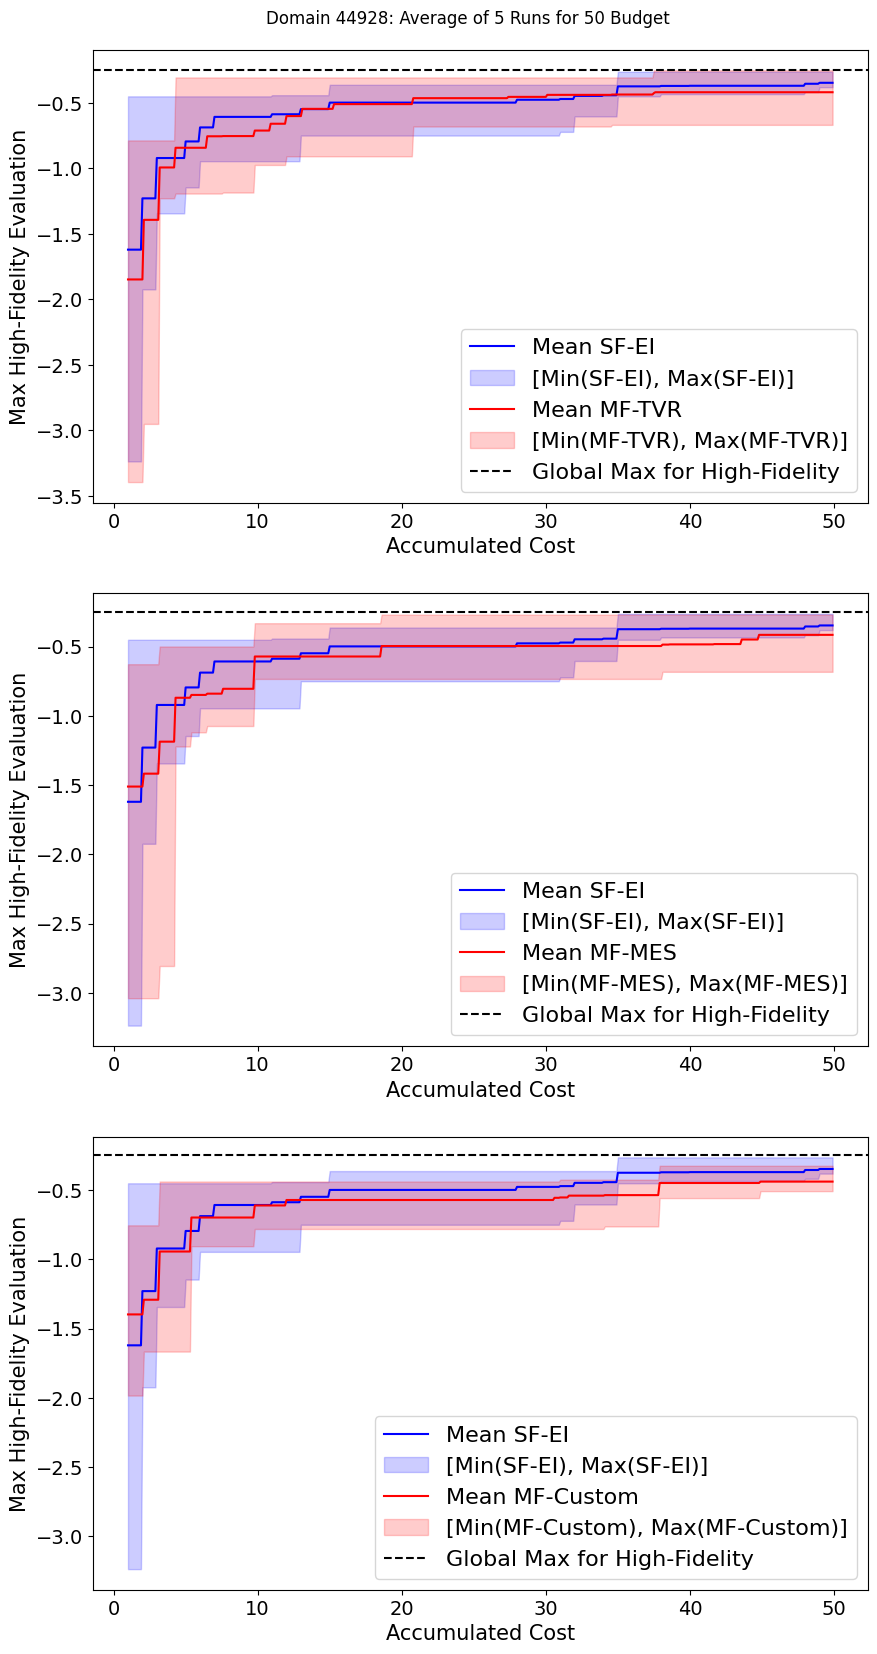

In [13]:
plot_pairwise(domain, modelDict, main_key='SF-EI', lf=0.1, allocated_budget=ALLOCATED_BUDGET_BATCH, no_of_expts= N_EXP_BATCH)
# plot_cost_batch(domain, searchDictBatch, allocated_budget=ALLOCATED_BUDGET_BATCH, title='Test')

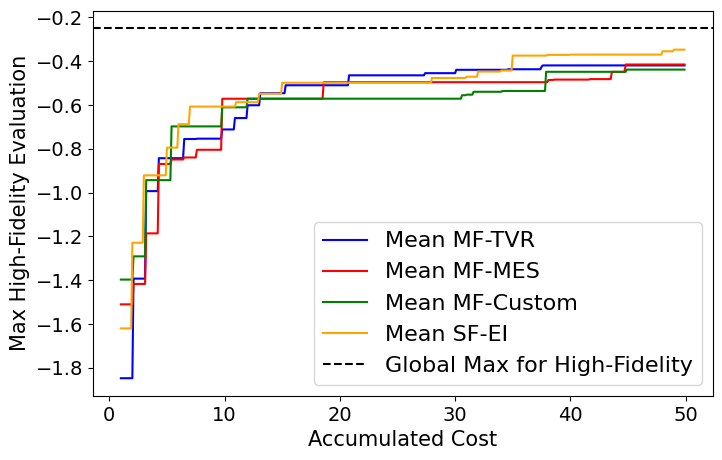

In [14]:
# Helper Function for Batch Case. This takes the cumulative cost array, extracts the high-fidelity targets, calculates the maximum up-to-that-stage
# and then spreads it out evenly over an  assigned range of regular intervals (of cumulative cost).
# i.e. the cost_range_input, so that we can compare different runs/experiments and compute an average.
# For example, if we have accumulated cost of [1, 1.5, 2, 2.5, 3.5] with targets [2.1, 0.9, 3.5, 2.3, 5].
# This should give an output over:
# [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] - see, evenly spaced (which with MF isn't guaranteed)
# [2.1, 2.1, 3.5, 3.5,   3.5, 5,   5,   5,  5 ] - we only take the maximum hf target.

def discretise_cost_and_maximise(high_fidleity_points, cost_range_input, cumulative_cost_array_input, hf_indices_input):
    accum_target = []
    # This part generates the accumulated maximum of just each high-fidleity point so far.
    for i in range(len(high_fidleity_points)):
        accum_target.append(max(high_fidleity_points[0:i+1]))

    accum_target = np.array(accum_target)
    max_target = []
    #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
    cumulative_cost_array_input_times_100 = np.array([int(x*100) for x in cumulative_cost_array_input])
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input_times_100[ hf_indices_input ]:
            max_target.append(accum_target[np.where(cumulative_cost_array_input_times_100[ hf_indices_input ] == x )[0]][0].item())
        elif id == 0:
            max_target.append(-6)
        else:
            max_target.append(max_target[id-1])
    return max_target

# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch_paper(domain, dictionary, title, allocated_budget, lf = 0.1, colour=['blue', 'red', 'green', 'orange', 'purple']):
    figure = plt.figure(figsize=(8,5))  
    max_in_space= np.max(domain[np.where(domain[:, -1] == 1.0)][:, -2])
    for id, search_alg in enumerate(dictionary):
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        
        #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
        cost_range = list(np.arange(1* 100,allocated_budget*100, int(lf*100)))
        
        for batch_no in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array([round(x,1) for x in cumulative_cost_batch[batch_no]])
            hf_indices = train_x_full_batch[batch_no][:, -1]==1.0
            high_fidelity_obj = train_obj_batch[batch_no][np.where(train_x_full_batch[batch_no][:, -1]==1.0)].reshape(-1,1)
            max_target = discretise_cost_and_maximise(high_fidelity_obj, cost_range, cumulative_cost_array, hf_indices)
            aggregate_max_target.append(max_target)
        
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        elts_above = []
        elts_below = []
        aggregate_max_target_swapped = np.swapaxes(aggregate_max_target,0,1)
        for idx, budget_elts in enumerate(aggregate_max_target_swapped):
            above_batch = []
            below_batch= []
            for budget_elt in budget_elts:
                if budget_elt >= maximum_aggregate_mean[idx]:
                    above_batch.append(budget_elt)
                if budget_elt <= maximum_aggregate_mean[idx]:
                    below_batch.append(budget_elt)
            elts_above.append(above_batch)
            elts_below.append(below_batch)
        maximum_aggregate_lowerbound = np.array([np.min(x) for x in elts_below])
        maximum_aggregate_upperbound =  np.array([np.max(x) for x in elts_above])

        cost_range_scaled = [x/100 for x in cost_range]
        plt.plot(cost_range_scaled, maximum_aggregate_mean, label=f'Mean {search_alg}', color=colour[id])
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.legend(loc='lower right')

plt.rcdefaults()
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=16)
plt.rc('axes', titlesize=16)
plot_cost_batch_paper(domain, modelDict, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, lf=0.1 )
plt.show()

In [17]:
# Instantaneous Regret and Cumulative Regret.
# We focus only on the high-fidelity points.
def discretise_evenly_for_averaging(stepwise_objective_points, cost_range_input, cumulative_cost_array_input, hf_evaluations):
    obj_target = []
    hf_evaluations_stretched = []
    #We multiply by 100 to get past the floating point arithmetic errors when dealing with fidelities and intervals of 0.1, say.
    # In this code we take the list of target evaluations which have already been "smoothed" across the x_train and "smooth" it
    # further across the cost_range. The cost_range is the more granular interval we are creating so that we can compare different
    # search-algorithsm, or different iterations of the same search-algorithm.
    # We also "smooth" out the hf_evaluations - this is a tally of the number of hf-evaluations so for over the cost_range_input.

    cumulative_cost_array_input_times_100 = np.array([int(x*100) for x in cumulative_cost_array_input])
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input_times_100:
            obj_target.append(stepwise_objective_points[np.where(cumulative_cost_array_input_times_100 == x )[0]][0].item())
            hf_evaluations_stretched.append(hf_evaluations[np.where(cumulative_cost_array_input_times_100 == x )[0]][0].item())
        elif id == 0:
            obj_target.append(0)
            hf_evaluations_stretched.append(1)
        else:
            obj_target.append(obj_target[id-1])
            hf_evaluations_stretched.append(hf_evaluations_stretched[id-1])
    return obj_target, hf_evaluations_stretched

def create_cumulative_regret(domain, train_x_batch, train_obj_batch, cumulative_cost_batch, cost_range, cum=True):
    max_in_space= np.max(domain[np.where(domain[:, -1] == 1.0)][:, -2])
    aggregate_regret = []
    for batch_no in range(len(train_x_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[batch_no])
            obj_modified = []
            # Since we want to compute the cumulative cost per high-fidelity evaluation, we need to
            # get some sort of list of the number of high-fidelity evaluations so far and when it's a lf call we keep the hf constant.
            # For example, [hf,lf,lf,hf,lf, hf, hf] = [1,1,1,2,2, 3, 4]
            hf_cum= []
            hf_count = 0
            for i in range(len(train_obj_batch[batch_no])):
                if train_x_batch[batch_no][i, -1]==1.0:
                    hf_count+=1
                    obj_modified.append(train_obj_batch[batch_no][i].item())
                    hf_cum.append(hf_count)
                else:
                    # If low-fidelity point, just take last high-fidelity point.
                    candidate = 0 if i ==0 else obj_modified[-1]
                    obj_modified.append(candidate)
                    hf_cum.append(hf_count)
            obj_modified = np.array(obj_modified)
            hf_cum= np.array(hf_cum)
            even_obj_over_range, hf_cum_stretched_out_over_range = discretise_evenly_for_averaging(obj_modified, cost_range, 
                                                                                                   cumulative_cost_array, 
                                                                                                   hf_cum)
            
            instantaneous_regret_per_hf_evaluation = (max_in_space - np.array(even_obj_over_range)) / hf_cum_stretched_out_over_range

            cumulative_regret = [sum(instantaneous_regret_per_hf_evaluation[: i + 1]) for i in range(len(instantaneous_regret_per_hf_evaluation))]
            # cumulative_regret_per_hf_evaluation = cumulative_regret / hf_cum_stretched_out_over_range
            regret = cumulative_regret if cum else instantaneous_regret_per_hf_evaluation
            aggregate_regret.append(regret)
            
    aggregate_regret_mean = np.mean(aggregate_regret, axis = 0)
    aggregate_regret_lowerbound = aggregate_regret_mean - np.std(aggregate_regret, axis = 0)
    aggregate_regret_upperbound = aggregate_regret_mean + np.std(aggregate_regret, axis = 0)
    return aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound
            
def plot_instantaneous_and_cumulative_regret_batch(domain, dictionary, title, allocated_budget, cum=True, lf=0.5, colour=['blue', 'red', 'green', 'yellow']):
    # plt.figure(figsize=(16, 15))
    for id, search_alg in enumerate(dictionary):
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
        cost_range = list(np.arange(1* 100, allocated_budget*100, int(lf*100)))
        aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound = create_cumulative_regret(domain, 
                                                                                                                   train_x_full_batch, 
                                                                                                                   train_obj_batch, 
                                                                                                                   cumulative_cost_batch, 
                                                                                                                   cost_range, 
                                                                                                                   cum)
        cost_range_scaled = [x/100 for x in cost_range]
        plt.plot(cost_range_scaled, aggregate_regret_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range_scaled, y1=aggregate_regret_lowerbound, y2=aggregate_regret_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    

    plt.xlabel('Accumulated Cost')
    plt.ylabel(f'{"Cumulative" if cum else "Instantaneous"} Regret per HF Evaluation')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor = (0, -0.2, 1, 1),
           bbox_transform = plt.gcf().transFigure)
    # plt.title(title)
    # plt.legend(loc='upper left')


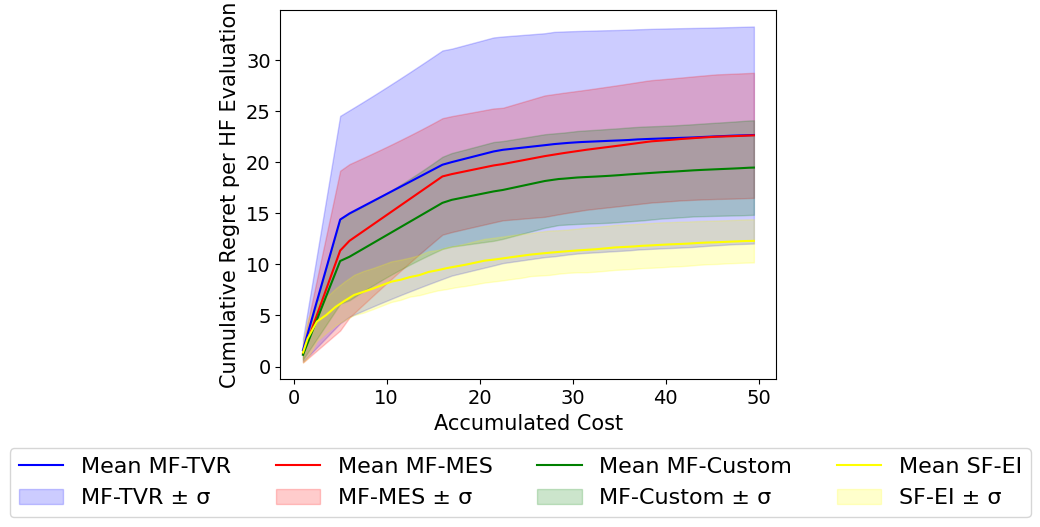

In [18]:
plot_instantaneous_and_cumulative_regret_batch(domain, modelDict, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, cum=True )